[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ellisalicante/GraphRewiring-Tutorial/blob/main/3-Inductive-Rewiring-CTLayer.ipynb)
# Inductive rewiring using CT-Layer
***Tutorial on Graph Rewiring: From Theory to Applications in Fairness***

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ellisalicante/GraphRewiring-Tutorial/blob/main/3-Inductive-Rewiring-CTLayer.ipynb)

## Environment preparation

In [2]:
COLLAB_ENV = True

In [3]:
import os
import torch

In [4]:
if COLLAB_ENV:
  !git clone https://github.com/ellisalicante/GraphRewiring-Tutorial
  !cd GraphRewiring-Tutorial && git submodule update --init --recursive
  !mv GraphRewiring-Tutorial/* ./
  !rm -rf GraphRewiring-Tutorial
    
  os.environ['TORCH'] = torch.__version__
  print(torch.__version__)
  !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
  !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
  !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


Cloning into 'GraphRewiring-Tutorial'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 32 (delta 11), reused 23 (delta 7), pack-reused 0
Unpacking objects: 100% (32/32), done.
Submodule 'DiffWire' (https://github.com/AdrianArnaiz/DiffWire/) registered for path 'DiffWire'
Cloning into '/content/GraphRewiring-Tutorial/DiffWire'...
Submodule path 'DiffWire': checked out '5aded812451639187680c2d70bf16f4d2f21ca2e'
mv: cannot move 'GraphRewiring-Tutorial/DiffWire' to './DiffWire': Directory not empty
mv: cannot move 'GraphRewiring-Tutorial/figs' to './figs': Directory not empty
1.12.1+cu113


In [5]:
import sys
sys.path.append("./DiffWire")

In [6]:
from DiffWire.transforms import FeatureDegree
from DiffWire.layers.utils.ein_utils import _rank3_diag, _rank3_trace
from DiffWire.layers.MinCut_Layer import dense_mincut_pool

import torch.nn.functional as F
from torch.nn import Linear

from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset
from torch_geometric.nn import DenseGraphConv
from torch_geometric.utils import to_dense_batch, to_dense_adj
from torch_geometric.utils import to_networkx

import networkx as nx

import numpy as np

from scipy.linalg import fractional_matrix_power
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize


import matplotlib.pyplot as plt

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device, torch.cuda.is_available()

(device(type='cuda'), True)

In [9]:
!nvidia-smi

Wed Dec  7 15:32:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    26W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Graph Classification with CT-Layer

### Train with CT-Layer

#### CT-Layer

For using it straightforward from the **[DiffWire repository](https://github.com/AdrianArnaiz/DiffWire)**:
```python
from DiffWire.layers.CT_layer import dense_CT_rewiring
```
**However, for the sake of clarity of the tutorial, we will explain the content of that function line by line**

<a href ="https://paperswithcode.com/method/ct-layer"> <img src="https://production-media.paperswithcode.com/methods/305a898a-e0a2-4d74-b8e8-c12839496577.png" alt="CT Layer" style="width:500px;"/> </a>

In [10]:
def dense_CT_rewiring(x, adj, s, mask=None, EPS=1e-15):
    """Rewires a Graph using CT Distance (Effective Resistances) given 's' as the CT Embedding. 
    Returns the new adjacency, and the loss for the CT Embbeding (s).

    Args:
        x (dense): feature matrix: NxF
        adj (dense): dense adjacency matrix: NxN
        s (dense): CT Embedding: NxH (H: size of latent space)
        mask (dense): dense mask of batches
        EPS (float): epsilon to avoid nans

    Returns:
        adj: new adjacency = CTdist/vol(G)
        loss: Cut Loss for CT Embedding (s)
        ortho_loss: Loss regularization orthogonality in CT Embedding (s)
    """
    x = x.unsqueeze(0) if x.dim() == 2 else x # adj torch.Size([b, N, f])
    adj = adj.unsqueeze(0) if adj.dim() == 2 else adj # adj torch.Size([b, N, N]) 
    s = s.unsqueeze(0) if s.dim() == 2 else s # s torch.Size([b, N, k])
    
    s = torch.tanh(s) # torch.Size([20, N, k]) One k for each N of each graph
    
    # batck masking
    (batch_size, num_nodes, _), k = x.size(), s.size(-1)
    if mask is not None:
        mask = mask.view(batch_size, num_nodes, 1).to(x.dtype)
        x, s = x * mask, s * mask 

    
    # Calculate CT_dist (distance matrix)
    CT_dist = torch.cdist(s,s) # [20, N, k], [20, N, k]-> [20,N,N]
    ## Calculate degree d_flat and degree matrix d
    d_flat = torch.einsum('ijk->ij', adj) # torch.Size([b, N]) 
    d = _rank3_diag(d_flat)+EPS  # d torch.Size([b, N, N])
    ## Calculate Vol (volumes): one per graph 
    vol = _rank3_trace(d) # torch.Size([20]) 
    ## Calculate out_adj as CT_dist/vol(G)
    N = adj.size(1)
    CT_dist = (CT_dist) / vol.unsqueeze(1).unsqueeze(1)
    ## Mask with adjacency
    adj = CT_dist*adj
    
    
    # Losses
    ## Calculate Laplacian L = D - A 
    L = d - adj
    ## Calculate out_adj as A_CT = S.T*L*S
    out_adj = torch.matmul(torch.matmul(s.transpose(1, 2), L), s) #[b, k, N]*[b, N, N]-> [b, k ,N]*[b, N, k] = [20, k, k]
    ## Calculate CT_num 
    CT_num = _rank3_trace(out_adj) # mincut_num torch.Size([b]) one sum over each graph
    ## Calculate CT_den 
    CT_den = _rank3_trace(
        torch.matmul(torch.matmul(s.transpose(1, 2), d ), s))+EPS # [b, k, N]*[b, N, N]->[b, k, N]*[b, N, k] -> [b] one sum over each graph

    CT_loss = CT_num / CT_den
    CT_loss = torch.mean(CT_loss) # Mean over batch!
    
    ## Orthogonality regularization.
    ss = torch.matmul(s.transpose(1, 2), s)  #[b, k, N]*[b, N, k]-> [b, k, k]
    i_s = torch.eye(k).type_as(ss) # [k, k]
    ortho_loss = torch.norm(
        ss / torch.norm(ss, dim=(-1, -2), keepdim=True) -
        i_s)
    ortho_loss = torch.mean(ortho_loss) # Mean over batch!
    
    return adj, CT_loss, ortho_loss

#### GNN using CT-Layer

<img src="https://github.com/ellisalicante/GraphRewiring-Tutorial/blob/main/figs/ctnetwork.png?raw=1" alt="CT network" style="width:300px;"/> </a>

In [ ]:
class CTNet(torch.nn.Module):
    def __init__(self, in_channels, out_channels, k_centers, hidden_channels=32, EPS=1e-15):
        super(CTNet, self).__init__()
        
        self.EPS=EPS
        #Message Passing Layers
        self.conv1 = DenseGraphConv(hidden_channels, hidden_channels)
        self.conv2 = DenseGraphConv(hidden_channels, hidden_channels)
        
        # Pooling for CT embedding
        num_of_centers1 =  k_centers # k1 #order of number of nodes
        self.pool1 = Linear(hidden_channels, num_of_centers1)
        
        # Pooling for MinCut Layer
        num_of_centers2 =  16 # k2 #mincut 
        self.pool2 = Linear(hidden_channels, num_of_centers2) 

        # MLPs towards out 
        self.lin1 = Linear(in_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)
        self.lin3 = Linear(hidden_channels, out_channels)
 

    def forward(self, x, edge_index, batch):    # x torch.Size([N, N]),  data.batch  torch.Size([661])  
        # Make all matrices dense
        adj = to_dense_adj(edge_index, batch)   # adj torch.Size(B, N, N])
        x, mask = to_dense_batch(x, batch)      

        #First layer: linear MLP
        x = self.lin1(x) 
        
        if torch.isnan(adj).any():
              print("adj nan")
        if torch.isnan(x).any():
              print("x nan")
        
        # CT REWIRING
        s1  = self.pool1(x)
        #adj = torch.Size([b, N, h]) --> CT Embedding
        adj, CT_loss, ortho_loss1 = dense_CT_rewiring(x, adj, s1, mask, EPS = self.EPS) 
        #adj = torch.Size([b, N, N]) --> CT Distances
        

        # CONV1: Now on x and rewired adj: 
        x = self.conv1(x, adj) #out: x torch.Size([20, N, F'=32])

        # MINCUT_POOL - Garph pooling
        # MLP of k=16 outputs s
        s2 = self.pool2(x) # s torch.Size([20, N, k])
        
        # Call to dense_cut_mincut_pool to get coarsened x, adj and the losses: k=16
        x, adj, mincut_loss2, ortho_loss2 = dense_mincut_pool(x, adj, s2, mask, EPS=self.EPS) # out x torch.Size([20, k=16, F'=32]),  adj torch.Size([20, k2=16, k2=16])

        # CONV2: Now on coarsened x and adj: 
        x = self.conv2(x, adj) #out x torch.Size([20, 16, 32])
        
        # Readout for each of the 20 graphs
        x = x.sum(dim=1) 
        
        # Final MLP for graph classification: hidden channels = 32
        x = F.relu(self.lin2(x)) 
        x = self.lin3(x) 
        
        #loss functions
        CT_loss = CT_loss + ortho_loss1
        mincut_loss = mincut_loss2 + ortho_loss2
        
        return F.log_softmax(x, dim=-1), CT_loss, mincut_loss


In [25]:
def train(epoch, loader):
    model.train()
    loss_all = 0
    correct = 0
    #i = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out, mc_loss, o_loss = model(data.x, data.edge_index, data.batch) # data.batch  torch.Size([783])
        loss = F.nll_loss(out, data.y.view(-1)) + mc_loss + o_loss
        loss.backward()
        loss_all += data.y.size(0) * loss.item()
        optimizer.step()
        correct += out.max(dim=1)[1].eq(data.y.view(-1)).sum().item() #accuracy in train AFTER EACH BACH
    return loss_all / len(loader.dataset), correct / len(loader.dataset)

@torch.no_grad()
def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        pred, mc_loss, o_loss = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(pred, data.y.view(-1)) + mc_loss + o_loss
        correct += pred.max(dim=1)[1].eq(data.y.view(-1)).sum().item()

    return loss, correct / len(loader.dataset)

#### Load Dataset and split

**Change `batch_size` depending on the availability of you memory**

In [ ]:
#TRAIN_SPLIT = 1500
#BATCH_SIZE = 16
#num_of_centers = 100
#dataset = TUDataset(root='data',name="REDDIT-BINARY", transform = FeatureDegree())

#TRAIN_SPLIT = 4500
#BATCH_SIZE = 16
#num_of_centers = 50
#dataset = TUDataset(root='data',name="COLLAB", transform = FeatureDegree())

TRAIN_SPLIT = 800
BATCH_SIZE = 16
num_of_centers = 20
dataset = TUDataset(root='data',name="IMDB-BINARY", transform = FeatureDegree())

In [ ]:
seed = 12345
torch.manual_seed(12345)
stratified = True

if stratified:
  train_indices, test_indices = train_test_split(list(range(len(dataset.data.y))), test_size=0.15, 
                                                stratify=dataset.data.y,
                                                random_state=seed, shuffle=True)

  train_dataset = torch.utils.data.Subset(dataset, train_indices)
  test_dataset = torch.utils.data.Subset(dataset, test_indices)

  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)  
else:
  dataset = dataset.shuffle()
  train_dataset = dataset[:TRAIN_SPLIT]
  test_dataset = dataset[TRAIN_SPLIT:]
  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

#### Create model and train

In [ ]:
EPS = 1e-15
epochs = 60

model = CTNet(dataset.num_features, dataset.num_classes, k_centers=num_of_centers, EPS=EPS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)


In [ ]:
optimizer.zero_grad()
for epoch in range(1, epochs):
    train_loss, train_acc = train(epoch, train_loader)
    #_, train_acc = test(train_loader)
    _, test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.5059, Test Acc: 0.4600
Epoch: 002, Train Acc: 0.5682, Test Acc: 0.4200
Epoch: 003, Train Acc: 0.5906, Test Acc: 0.5467
Epoch: 004, Train Acc: 0.6082, Test Acc: 0.5733
Epoch: 005, Train Acc: 0.5871, Test Acc: 0.6400
Epoch: 006, Train Acc: 0.6282, Test Acc: 0.6333
Epoch: 007, Train Acc: 0.6306, Test Acc: 0.4733
Epoch: 008, Train Acc: 0.6082, Test Acc: 0.4600
Epoch: 009, Train Acc: 0.6341, Test Acc: 0.7267
Epoch: 010, Train Acc: 0.6647, Test Acc: 0.7133
Epoch: 011, Train Acc: 0.6224, Test Acc: 0.6933
Epoch: 012, Train Acc: 0.6518, Test Acc: 0.6400
Epoch: 013, Train Acc: 0.6576, Test Acc: 0.6667
Epoch: 014, Train Acc: 0.6541, Test Acc: 0.6800
Epoch: 015, Train Acc: 0.6482, Test Acc: 0.7333
Epoch: 016, Train Acc: 0.6541, Test Acc: 0.7000
Epoch: 017, Train Acc: 0.5941, Test Acc: 0.4733
Epoch: 018, Train Acc: 0.6388, Test Acc: 0.7133
Epoch: 019, Train Acc: 0.6259, Test Acc: 0.5333
Epoch: 020, Train Acc: 0.5953, Test Acc: 0.5067
Epoch: 021, Train Acc: 0.6118, Test Acc:

### Inspecting CT Layer: CT Distances and CT Embedding

We will analyze the predicted CT distances and CT embedding, in order to better understand the rewiring and to to one’s imagination run riot in the use of commute times embedding $\mathbf{Z}$ and commute times distance $\mathbf{T^{CT}}$ (i.e. effective resistance)




In [18]:
#num_of_centers = 420 #REDDIT model was trained with center=average degree of the graphs in the dataset (see DiffWire paper for more details)
#dataset = TUDataset(root='data',name="REDDIT-BINARY", transform = FeatureDegree())

num_of_centers = 20
dataset = TUDataset(root='data',name="IMDB-BINARY", transform = FeatureDegree())

In [53]:
BATCH_SIZE = 16
full_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
indiv_loader = DataLoader(dataset, batch_size=1, shuffle=False)

In [49]:
# get cc graphs
connected_graphs = []
for i, g in enumerate(indiv_loader):
  G = to_networkx(g, node_attrs=["x"], to_undirected=True)
  if nx.is_connected(G):
    connected_graphs.append(g)

del g,i,G

In [21]:
#trained_model_path = "DiffWire/trained_models/CTNet/REDDIT-BINARY_CTNet_17_05_22__08_50_iter0.pth"
trained_model_path = "DiffWire/trained_models/CTNet/IMDB-BINARY_CTNet_17_05_22__08_56_iter0.pth"

In [52]:
#@title GNN using CT-Layer and **saving CTEmbedding and CTDist**

class CTNet_latent(torch.nn.Module):
    def __init__(self, in_channels, out_channels, k_centers, hidden_channels=32, EPS=1e-15):
        super(CTNet_latent, self).__init__()
        
        self.EPS=EPS
        #Message Passing Layers
        self.conv1 = DenseGraphConv(hidden_channels, hidden_channels)
        self.conv2 = DenseGraphConv(hidden_channels, hidden_channels)
        
        # Pooling for CT embedding
        num_of_centers1 =  k_centers # k1 #order of number of nodes
        self.pool1 = Linear(hidden_channels, num_of_centers1)
        
        # Pooling for MinCut Layer
        num_of_centers2 =  16 # k2 #mincut 
        self.pool2 = Linear(hidden_channels, num_of_centers2) 

        # MLPs towards out 
        self.lin1 = Linear(in_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)
        self.lin3 = Linear(hidden_channels, out_channels)

        self.ct_embedding = None
        self.new_adj = None
 

    def forward(self, x, edge_index, batch):    # x torch.Size([N, N]),  data.batch  torch.Size([661])  
        # Make all matrices dense
        adj = to_dense_adj(edge_index, batch)   # adj torch.Size(B, N, N])
        x, mask = to_dense_batch(x, batch)      

        #First layer: linear MLP
        x = self.lin1(x) 
        
        if torch.isnan(adj).any():
              print("adj nan")
        if torch.isnan(x).any():
              print("x nan")
        
        # CT REWIRING
        s1  = self.pool1(x)
        self.ct_embedding = torch.tanh(s1.clone().detach())
        adj, CT_loss, ortho_loss1 = dense_CT_rewiring(x, adj, s1, mask, EPS = self.EPS) 
        self.new_adj = adj.clone()
        

        # CONV1: Now on x and rewired adj: 
        x = self.conv1(x, adj) #out: x torch.Size([20, N, F'=32])

        # MINCUT_POOL - Garph pooling
        s2 = self.pool2(x) 
        x, adj, mincut_loss2, ortho_loss2 = dense_mincut_pool(x, adj, s2, mask, EPS=self.EPS) # out x torch.Size([20, k=16, F'=32]),  adj torch.Size([20, k2=16, k2=16])

        # CONV2: Now on coarsened x and adj: 
        x = self.conv2(x, adj)
        
        # Readout for each of the 20 graphs
        x = x.sum(dim=1) 
        
        # Final MLP for graph classification: hidden channels = 32
        x = F.relu(self.lin2(x)) 
        x = self.lin3(x) 
        
        #loss functions
        CT_loss = CT_loss + ortho_loss1
        mincut_loss = mincut_loss2 + ortho_loss2
        
        return F.log_softmax(x, dim=-1), CT_loss, mincut_loss

Import trained model

In [33]:
model =  CTNet_latent(dataset.num_features, dataset.num_classes,num_of_centers).to(device)
model.load_state_dict(torch.load(trained_model_path, map_location=torch.device(device)))
model.to(device)
model.eval()

CTNet_latent(
  (conv1): DenseGraphConv(32, 32)
  (conv2): DenseGraphConv(32, 32)
  (pool1): Linear(in_features=32, out_features=20, bias=True)
  (pool2): Linear(in_features=32, out_features=16, bias=True)
  (lin1): Linear(in_features=1, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=32, bias=True)
  (lin3): Linear(in_features=32, out_features=2, bias=True)
)

In [34]:
#test loaded model
loss, acc = test(full_loader)
print(loss, acc)

tensor(14.3905, device='cuda:0') 0.715


#### CT Rewiring

In [356]:
#Select a graph
from itertools import islice
#graph_i = connected_graphs[-10]
graph_i= next(islice(iter(indiv_loader),234,None)) #15 in IMBD is complete graph, (0,1, 16, 17) clearly structured

G = to_networkx(graph_i, node_attrs=["x"], to_undirected=True)
degree = np.array(list(dict(G.degree).values()))
nx.is_connected(G), len(list(nx.connected_components(G))), G.number_of_nodes()

(True, 1, 13)

In [357]:
#predict the new adjacency
graph_i.to(device)
pred, mc_loss, o_loss = model(graph_i.x, graph_i.edge_index, graph_i.batch)
loss_graph = F.nll_loss(pred,graph_i.y.view(-1)) + mc_loss + o_loss
print('correct graph classification?', bool(pred.max(dim=-1)[1].eq(graph_i.y.view(-1)).sum().item()))
rewired_adj = model.new_adj.detach().cpu().squeeze()
rewired_adj.shape

correct graph classification? True


torch.Size([13, 13])

In [358]:
def get_cbar(cmap, array):
  wmin = min(array)
  wmax = max(array)
  return plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = wmin, vmax=wmax))

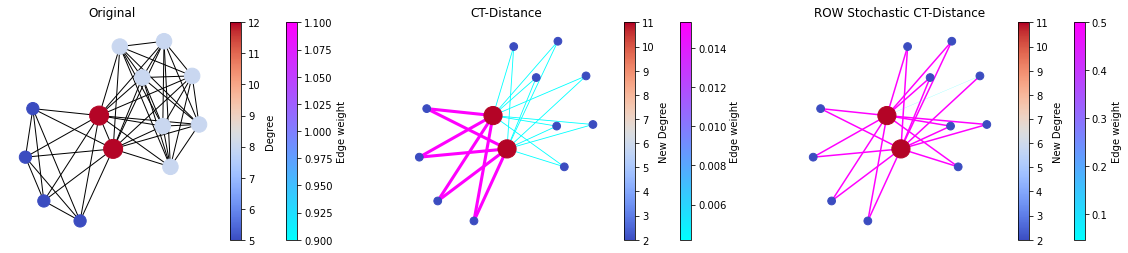

In [359]:
fig = plt.figure(figsize=(20,4), constrained_layout=True)

ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1))
ax3 = plt.subplot2grid((1, 3), (0, 2))

node_cmap = plt.cm.coolwarm
edge_cmap = plt.cm.cool

####### ORIGINAL
degree = np.array(list(dict(G.degree).values()))
pos = nx.kamada_kawai_layout(G)
#pos = nx.spring_layout(G)
nx.draw(G, node_color = degree, cmap=node_cmap, pos=pos, node_size=degree*30, ax=ax1)

plt.colorbar(get_cbar(edge_cmap, [1]*G.number_of_nodes()), label='Edge weight', orientation="vertical", ax=ax1)
plt.colorbar(get_cbar(node_cmap, degree), label='Degree', orientation="vertical", ax=ax1)
ax1.set_title('Original')

######### REWIRED
H = nx.from_numpy_matrix(np.asmatrix(rewired_adj))
#totally connected lead to totally disconnected
if len(torch.nonzero(rewired_adj)) > 0:
  edges, weights = zip(*nx.get_edge_attributes(H,'weight').items())
  new_degree = np.array(list(dict(H.degree).values()))
else:
  edges = []
  weights= np.array([0])
  new_degree = np.array([1]*H.number_of_nodes())

#posH = nx.kamada_kawai_layout(H)

#draw
nx.draw(H, node_color = new_degree, cmap=node_cmap, pos=pos, node_size=new_degree*30, 
        edgelist=edges, edge_color=weights, width=np.array(weights)*200, edge_cmap=edge_cmap, ax=ax2)
#colorbar
fig.colorbar(get_cbar(edge_cmap, weights), label='Edge weight', orientation="vertical", ax=ax2)
fig.colorbar(get_cbar(node_cmap, new_degree), label='New Degree', orientation="vertical", ax=ax2)
ax2.set_title('CT-Distance')


######### REWIRED and row-stochastic
new_matrix = normalize(rewired_adj,axis=1, norm='l1')
H = nx.from_numpy_matrix(np.asmatrix(new_matrix))
#totally connected lead to totally disconnected

if len(torch.nonzero(rewired_adj)) > 0:
  edges, weights = zip(*nx.get_edge_attributes(H,'weight').items())
  new_degree = np.array(list(dict(H.degree).values()))
else:
  edges = []
  weights= np.array([0])
  new_degree = np.array([1]*H.number_of_nodes())

#posH = nx.kamada_kawai_layout(H)

#draw
nx.draw(H, node_color = new_degree, cmap=node_cmap, pos=pos, node_size=new_degree*30, 
        edgelist=edges, edge_color=weights, width=np.array(weights)*3, edge_cmap=edge_cmap, ax=ax3)
#colorbar
fig.colorbar(get_cbar(edge_cmap, weights), label='Edge weight', orientation="vertical", ax=ax3)
fig.colorbar(get_cbar(node_cmap, new_degree), label='New Degree', orientation="vertical", ax=ax3)
ax3.set_title('ROW Stochastic CT-Distance')
#plt.tight_layout()
plt.show()

#### CT Embedding

In [304]:
def visualize(z, color, size=10, save=False, title='img', ax=None):
    plt.figure(figsize=(5,5))
    plt.scatter(z[:, 0], z[:, 1], s=size, c=color, cmap="seismic")
    plt.colorbar()
    plt.xticks([], [])
    plt.yticks([], [])
    if save:
        plt.savefig(title+'.pdf')
     
    plt.show()

def graph_vol(G):
    A = nx.adjacency_matrix(G)
    D = A.sum(axis=1)
    D = D.squeeze()
    d = np.zeros(G.number_of_nodes())
    for i in range(G.number_of_nodes()):
        d[i] = D[0,i]
    vol = d.sum()
    return vol

def commute_times_embedding(G):

    A = nx.adjacency_matrix(G)
    n = G.number_of_nodes()
    vol = graph_vol(G)
    D = A.sum(axis=1)
    L = nx.normalized_laplacian_matrix(G)

    # Finding eigen values and eigen vectors
    e, evecs = np.linalg.eig(L.todense())
    # Sort them (both e's and evecs's) ascending
    idx =e.argsort()
    e = e[idx]
    evecs = evecs[:,idx]

    #Compute CTE
    Lambda = np.diag(e)
    Lambda = fractional_matrix_power(Lambda, -0.5)
    Lambda[0,0] = 0
    CTE = np.sqrt(vol)*np.matmul(Lambda,np.transpose(evecs))
    # Embedding is in the columns
    return CTE

**Select a graph, calculate Spectral CT, predicted CT by CT-Layer and plot**

Ideally we select connected graphs for a fair comparison with Spectral CT (CT computed spectrally has complex numbers if disconnected)

You can select the graph yourself, either from the list of connected graphs `connected_graphs[IDX]` or from all the graphs in the dataset `next(islice(iter(indiv_loader),IDX,None))`

In [305]:
G = to_networkx(graph_i, node_attrs=["x"], to_undirected=True)
degree = np.array(list(dict(G.degree).values()))
nx.is_connected(G), len(list(nx.connected_components(G))), G.number_of_nodes()

(True, 1, 12)

In [306]:
#Spectral CTE
degree = np.array(list(dict(G.degree).values()))
spectral_CTE = commute_times_embedding(G).T

In [307]:
#Learned CTE
graph_i.to(device)
pred, mc_loss, o_loss = model(graph_i.x, graph_i.edge_index, graph_i.batch)
loss_graph = F.nll_loss(pred,graph_i.y.view(-1)) + mc_loss + o_loss
print('correct pred?', bool(pred.max(dim=-1)[1].eq(graph_i.y.view(-1)).sum().item()))
learned_cte = model.ct_embedding.detach().cpu().squeeze()

correct pred? False


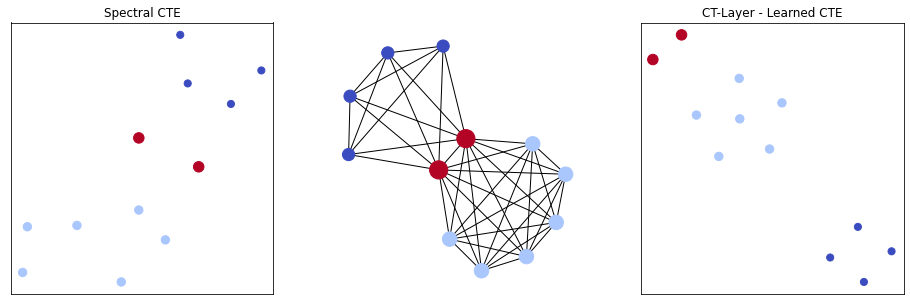

In [308]:
fig = plt.figure(figsize=(16,5))

ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1), rowspan=1)
ax3 = plt.subplot2grid((1, 3), (0, 2))

#pos = nx.spring_layout(G, seed=44)
nx.draw(G, node_color = degree, cmap="coolwarm", pos=pos, node_size=degree*30, ax=ax2)

learned_cte_2d = TSNE(n_components=2, learning_rate='auto',
               init='random', perplexity=6, early_exaggeration=100, random_state=200).fit_transform(learned_cte.real)
ax3.set_xticks([], [])
ax3.set_yticks([], [])
ax3.set_title('CT-Layer - Learned CTE')
ax3.scatter(learned_cte_2d[:, 0], learned_cte_2d[:, 1], s=degree*10, c=degree, cmap="coolwarm")

spec_cte_2d = TSNE(n_components=2, learning_rate='auto',
               init='random', perplexity=6, early_exaggeration=100, random_state=200).fit_transform(spectral_CTE.real)
ax1.set_xticks([], [])
ax1.set_yticks([], [])
ax1.set_title('Spectral CTE')
ax1.scatter(spec_cte_2d[:, 0], spec_cte_2d[:, 1], s=degree*10, c=degree, cmap="coolwarm")

plt.show()

## Node classification